c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


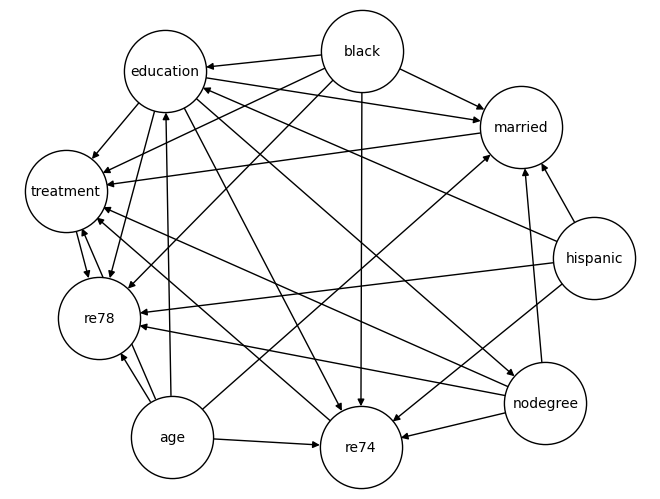

In [1]:
import os
import pandas as pd
import networkx as nx
import json
import dowhy
import random
import numpy as np
import re
import utils

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

LALONDE_COLS = ['treatment', 'age', 'education', 'black', 'hispanic', 'married','nodegree', 're74', 're78']

lalonde_original, nswre_df, cps_control, psid_control, cps2_control, cps3_control, psid2_control, psid3_control = utils.load_data()
nswre_cps, nswre_cps2, nswre_cps3, nswre_psid, nswre_psid2, nswre_psid3 = utils.load_combinations(nswre_df, cps_control, cps2_control, cps3_control,  psid_control, psid2_control, psid3_control)
lalonde_cps, lalonde_cps2, lalonde_cps3, lalonde_psid, lalonde_psid2, lalonde_psid3 = utils.load_combinations(lalonde_original, 
                                                                                                                           cps_control[LALONDE_COLS], 
                                                                                                                           cps2_control[LALONDE_COLS], 
                                                                                                                           cps3_control[LALONDE_COLS],  
                                                                                                                           psid_control[LALONDE_COLS], 
                                                                                                                           psid2_control[LALONDE_COLS], 
                                                                                                                           psid3_control[LALONDE_COLS])

graph = utils.extract_CD_graph("graph_1603") #Loads the graph from json
utils.draw_graph(graph) #plots the graph
combinations_dict = {"nswre_experiment": nswre_df, 
                     "nswre_cps": nswre_cps, 
                     "nswre_cps2": nswre_cps2, 
                     "nswre_cps3": nswre_cps3, 
                     "nswre_psid": nswre_psid, 
                     "nswre_psid2": nswre_psid2, 
                     "nswre_psid3": nswre_psid3}

lalonde_combinations_dict = {"lalonde_original": lalonde_original, 
                            "lalonde_cps": lalonde_cps, 
                            "lalonde_cps2": lalonde_cps2, 
                            "lalonde_cps3": lalonde_cps3, 
                            "lalonde_psid": lalonde_psid, 
                            "lalonde_psid2": lalonde_psid2, 
                            "lalonde_psid3": lalonde_psid3}

## Refutation section

In [ ]:
backdoor_list = ["backdoor.linear_regression", 
                 #"backdoor.distance_matching",     # need to specify a distance metric
                 #"backdoor.propensity_score_stratification", # not enough data for some combinations 
                 #"backdoor.propensity_score_matching", # takes a lot of time 
                 "backdoor.propensity_score_weighting"]

In [8]:
import econml

In [21]:
estimator_list = ["backdoor.propensity_score_weighting"]
method_params= [None]


result_dict = {}
for df_key, df_value in combinations_dict.items():
        auxiliar_df = {}
        model = dowhy.CausalModel(data=df_value, treatment="treatment", graph=graph, outcome="re78")
        identified_effect = model.identify_effect(proceed_when_unidentifiable=True)

        auxiliar_df["treatment"] = "treatment"
        auxiliar_df["outcome"] = "re78"

        lalonde_estimate = model.estimate_effect(identified_effect, 
                                                method_name="backdoor.propensity_score_weighting",
                                                )
        auxiliar_df["method_name"] = lalonde_estimate.value

        refute_result =  model.refute_estimate(identified_effect, lalonde_estimate, method_name="data_subset_refuter")
        print(refute_result)
        match = re.search(r'New effect:([-+]?\d*\.?\d+)', str(refute_result))
        pvalue = re.search(r'p value:([-+]?\d*\.?\d+)', str(refute_result))
        new_effect_value = str(np.round(float(match.group(1)),2)) +" (" + str(float(pvalue.group(1)))+")"
        auxiliar_df["refutation_name"] = new_effect_value
       
        result_dict[df_key] = auxiliar_df

result_df = pd.DataFrame.from_dict(result_dict, orient='index')

Refute: Use a subset of data
Estimated effect:1647.5252549793704
New effect:1637.0056909403813
p value:1.0

Refute: Use a subset of data
Estimated effect:-7532.327125937469
New effect:-7518.869483433326
p value:0.9

Refute: Use a subset of data
Estimated effect:-2893.9013238490033
New effect:-2871.593459130695
p value:0.94

Refute: Use a subset of data
Estimated effect:282.79932845581607
New effect:282.634511329274
p value:0.96

Refute: Use a subset of data
Estimated effect:-13652.094211551033
New effect:-13654.61383068219
p value:0.94

Refute: Use a subset of data
Estimated effect:-2421.9523840459206
New effect:-2483.2774154646245
p value:0.88

Refute: Use a subset of data
Estimated effect:1002.3907411298223
New effect:1003.8653520996838
p value:1.0



In [22]:
result_df.head()

,treatment,outcome,method_name,refutation_name
nswre_experiment,treatment,re78,1647.525255,1637.01 (1.0)
nswre_cps,treatment,re78,-7532.327126,-7518.87 (0.9)
nswre_cps2,treatment,re78,-2893.901324,-2871.59 (0.94)
nswre_cps3,treatment,re78,282.799328,282.63 (0.96)
nswre_psid,treatment,re78,-13652.094212,-13654.61 (0.94)


In [4]:
model = dowhy.CausalModel(data=df_value, treatment="treatment", graph=graph, outcome="re78")
identified_effect = model.identify_effect(proceed_when_unidentifiable=True)
refute_result =  model.refute_estimate(identified_effect, lalonde_estimate, method_name="data_subset_refuter")
print(refute_result)


Refute: Use a subset of data
Estimated effect:690.8366481861622
New effect:655.4264639269542
p value:0.88



In [ ]:
# def causal_effect(combinations_dict: dict, graph: nx.Graph, methods: list, refuter_list: list, treatment="treatment", outcome="re78") -> pd.DataFrame:
#     result_dict = {}
#     for df_key, df_value in combinations_dict.items():
#         auxiliar_df = {}
#         model = dowhy.CausalModel(data=df_value, treatment=treatment, graph=graph, outcome=outcome)
#         identified_effect = model.identify_effect(proceed_when_unidentifiable=True)

#         auxiliar_df["treatment"] = treatment
#         auxiliar_df["outcome"] = outcome
#         for method in methods:
#             lalonde_estimate = model.estimate_effect(identified_effect, 
#                                                     method_name=method,
#                                                     # target_units="ate",
#                                                     # method_params={"weighting_scheme":"ips_weight"}
#                                                     )
#             auxiliar_df[method] = lalonde_estimate.value

#             for refute in refuter_list:
#                 refute_result =  model.refute_estimate(identified_effect, lalonde_estimate, method_name=refute)
#                 match = re.search(r'New effect:([-+]?\d*\.?\d+)', str(refute_result))
#                 new_effect_value = np.round(float(match.group(1)),2)
#                 auxiliar_df[refute+method] = new_effect_value
       
#         result_dict[df_key] = auxiliar_df

#     result_df = pd.DataFrame.from_dict(result_dict, orient='index')

#     #prob_estimation = probabilistic_causal_effect(combinations_dict, graph)
#     #result_df = result_df.join(prob_estimation)

#     return result_df